In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import os

# 1. Start Spark session
spark = SparkSession.builder.appName("XRay Dataset From HDFS").getOrCreate()

# 2. Define HDFS paths and labels
base_path = "/xray_project"
labels = {
    "COVID": 0,
    "NORMAL": 1,
    "PNEUMONIA": 2
}

# 3. Create DataFrames from each folder
dfs = []
for folder, label in labels.items():
    path = f"hdfs://namenode:9000{base_path}/{folder}"
    
    # Use Hadoop FileSystem API to list files
    df = spark.read.format("binaryFile") \
        .option("pathGlobFilter", "*.png") \
        .load(path) \
        .withColumn("label", lit(label))
    
    dfs.append(df)

# 4. Union all DataFrames
full_df = dfs[0]
for df in dfs[1:]:
    full_df = full_df.union(df)

# 5. Show a few rows
full_df.select("path", "label").show(10, truncate=False)

+-----------------------------------------------------+-----+
|path                                                 |label|
+-----------------------------------------------------+-----+
|hdfs://namenode:9000/xray_project/COVID/Covid_220.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_179.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_263.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_212.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_510.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_503.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_521.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_505.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_506.png|0    |
|hdfs://namenode:9000/xray_project/COVID/Covid_456.png|0    |
+-----------------------------------------------------+-----+
only showing top 10 rows



In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, regexp_extract
import tensorflow as tf
from petastorm.tf_utils import make_petastorm_dataset
from petastorm.etl.dataset_metadata import materialize_dataset
from petastorm import make_batch_reader

In [12]:
# 5. Extract image filename from full path
full_df = full_df.withColumn("image_name", regexp_extract("path", r"([^/]+)$", 1))

# 6. Filter out corrupted/empty images
full_df = full_df.filter("length > 0")

# 7. Display a sample of processed data
full_df.select("image_name", "label", "length").show(5, truncate=False)

+-------------+-----+------+
|image_name   |label|length|
+-------------+-----+------+
|Covid_220.png|0    |581696|
|Covid_179.png|0    |576570|
|Covid_263.png|0    |575203|
|Covid_212.png|0    |563393|
|Covid_510.png|0    |555202|
+-------------+-----+------+
only showing top 5 rows



In [13]:
# 8. Split the dataset into Train, Validation, and Test sets
train_df, val_df, test_df = full_df.randomSplit([0.7, 0.2, 0.1], seed=42)

# 9. Show counts for each set
print("Train set count:", train_df.count())
print("Validation set count:", val_df.count())
print("Test set count:", test_df.count())

Train set count: 2756
Validation set count: 792
Test set count: 423


In [14]:
# 10. Save each set as Parquet to HDFS for Petastorm / TensorFlow integration
train_df.write.mode("overwrite").parquet("hdfs://namenode:9000/xray_project/parquet/train")
val_df.write.mode("overwrite").parquet("hdfs://namenode:9000/xray_project/parquet/val")
test_df.write.mode("overwrite").parquet("hdfs://namenode:9000/xray_project/parquet/test")

In [15]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark_df = spark.read.parquet("hdfs://namenode:9000/xray_project/parquet/train")
spark_df.printSchema()
spark_df.show(5)


root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: integer (nullable = true)
 |-- image_name: string (nullable = true)

+--------------------+--------------------+------+--------------------+-----+-------------+
|                path|    modificationTime|length|             content|label|   image_name|
+--------------------+--------------------+------+--------------------+-----+-------------+
|hdfs://namenode:9...|2025-05-23 15:00:...|411657|[89 50 4E 47 0D 0...|    0|Covid_102.png|
|hdfs://namenode:9...|2025-05-23 15:01:...|407247|[89 50 4E 47 0D 0...|    0|Covid_235.png|
|hdfs://namenode:9...|2025-05-23 15:01:...|404541|[89 50 4E 47 0D 0...|    0|Covid_236.png|
|hdfs://namenode:9...|2025-05-23 15:01:...|409010|[89 50 4E 47 0D 0...|    0|Covid_237.png|
|hdfs://namenode:9...|2025-05-23 15:01:...|413215|[89 50 4E 47 0D 0...|    0|Covid_272.png|
+---------------

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- 1. Define a generator to convert Spark RDD data into a tf.data.Dataset
def gen():
    for content, label in rdd_dataset.toLocalIterator():
        if isinstance(content, bytearray):
            content = bytes(content)
        if not isinstance(label, np.int32):
            label = np.int32(label)
        yield content, label

# Assume spark_df is the DataFrame containing images with columns 'content' and 'label'
rdd_dataset = spark_df.select("content", "label").rdd

# --- 2. Build Dataset from the generator
dataset = tf.data.Dataset.from_generator(
    gen,
    output_types=(tf.string, tf.int32),
    output_shapes=(tf.TensorShape([]), tf.TensorShape([]))
)

# --- 3. Function to decode binary content to image and normalize it
def preprocess(content, label):
    image = tf.io.decode_png(content, channels=1)  # decode image as grayscale
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# --- 4. Convert images from grayscale (1 channel) to RGB (3 channels) for ResNet50
def preprocess_resnet(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

dataset_rgb = dataset.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
for images, labels in dataset.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels:", labels.numpy())


Batch images shape: (224, 224, 1)
Batch labels: 0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

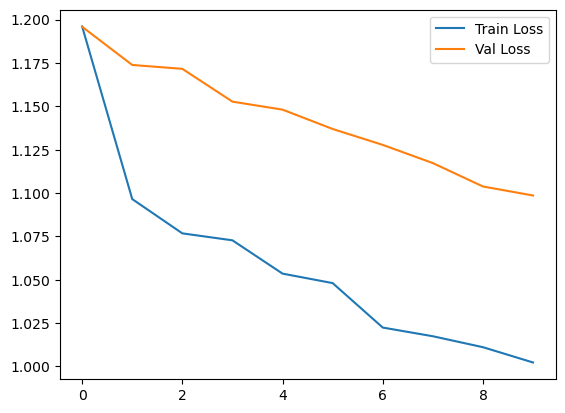

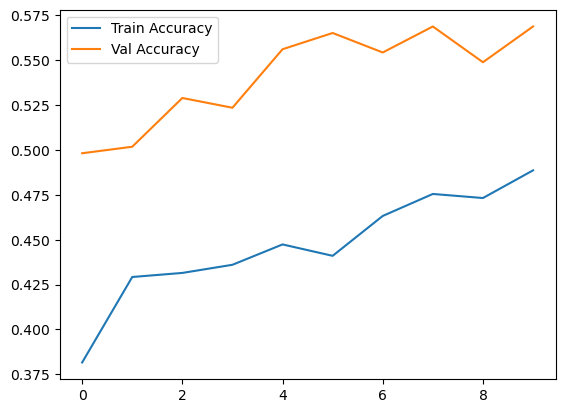

In [11]:
# --- 5. Split the data (if you have validation data)
# Example split: 80% training, 20% validation
dataset_size = dataset_rgb.reduce(0, lambda x, _: x + 1).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset_rgb.take(train_size)
val_dataset = dataset_rgb.skip(train_size)

# --- 6. Build ResNet50 model for 3-class classification
num_classes = 3

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 7. Prepare batches and optimize data loading
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# --- 8. Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# --- 9. Plot basic results for each epoch
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- 1. Define Generator to convert Spark RDD data into tf.data.Dataset
def gen():
    for content, label in rdd_dataset.toLocalIterator():
        if isinstance(content, bytearray):
            content = bytes(content)
        if not isinstance(label, np.int32):
            label = np.int32(label)
        yield content, label

# Assume spark_df is a DataFrame of images with columns 'content' and 'label'
rdd_dataset = spark_df.select("content", "label").rdd

# --- 2. Build Dataset from Generator
dataset = tf.data.Dataset.from_generator(
    gen,
    output_types=(tf.string, tf.int32),
    output_shapes=(tf.TensorShape([]), tf.TensorShape([]))
)

# --- 3. Function to decode binary content to image and normalize
def preprocess(content, label):
    image = tf.io.decode_png(content, channels=1)  # Decode grayscale image
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# --- 4. Convert grayscale (1 channel) images to RGB (3 channels) for ResNet50
def preprocess_resnet(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

dataset_rgb = dataset.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)

# --- 5. Split data (if you have validation data)
# Example: 80% training, 20% validation
dataset_size = dataset_rgb.reduce(0, lambda x, _: x + 1).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset_rgb.take(train_size)
val_dataset = dataset_rgb.skip(train_size)

# --- 6. Build ResNet50 model with 3 classes
num_classes = 3

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 7. Prepare batches and optimize data loading
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [19]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)


Epoch 1/20
69/69 [==============================] - 129s 2s/step - loss: 0.8857 - accuracy: 0.6053 - val_loss: 1.4118 - val_accuracy: 0.1721
Epoch 2/20
69/69 [==============================] - 132s 2s/step - loss: 0.7063 - accuracy: 0.6824 - val_loss: 1.2927 - val_accuracy: 0.3098
Epoch 3/20
69/69 [==============================] - 129s 2s/step - loss: 0.6069 - accuracy: 0.7473 - val_loss: 1.0788 - val_accuracy: 0.3768
Epoch 4/20
69/69 [==============================] - 126s 2s/step - loss: 0.5326 - accuracy: 0.7781 - val_loss: 0.8296 - val_accuracy: 0.6920
Epoch 5/20
69/69 [==============================] - 159s 2s/step - loss: 0.4742 - accuracy: 0.8076 - val_loss: 0.6467 - val_accuracy: 0.7138
Epoch 6/20
69/69 [==============================] - 127s 2s/step - loss: 0.4270 - accuracy: 0.8466 - val_loss: 0.6221 - val_accuracy: 0.7192
Epoch 7/20
69/69 [==============================] - 141s 2s/step - loss: 0.4047 - accuracy: 0.8503 - val_loss: 0.6145 - val_accuracy: 0.7283
Epoch 8/20
69

1/1 [==============================] - 1s 1s/step


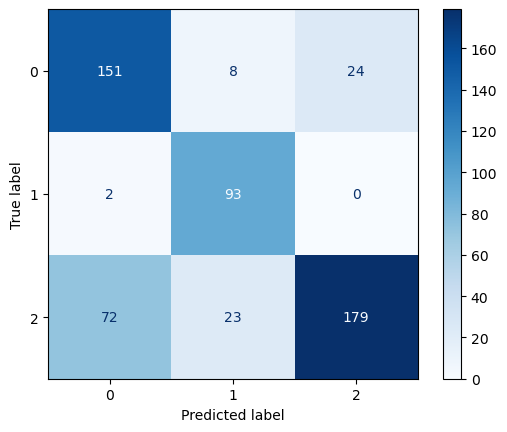

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


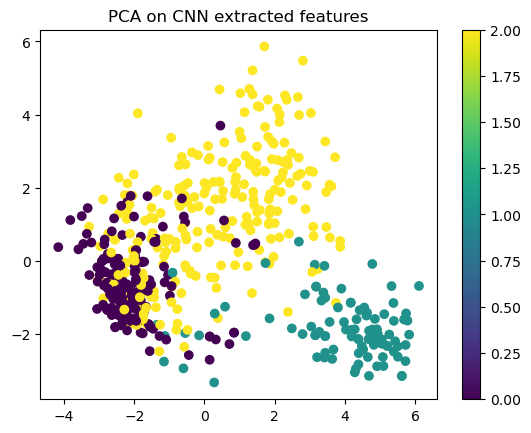

In [21]:
from sklearn.decomposition import PCA

# Extract features from the last layer before classification
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

features = []

for images, _ in val_dataset:
    feats = feature_extractor(images)
    features.append(feats.numpy())

features = np.concatenate(features, axis=0)

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
features_reduced = pca.fit_transform(features)

# Plot the results
plt.scatter(features_reduced[:, 0], features_reduced[:, 1], c=y_true, cmap='viridis')
plt.colorbar()
plt.title('PCA on CNN extracted features')
plt.show()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

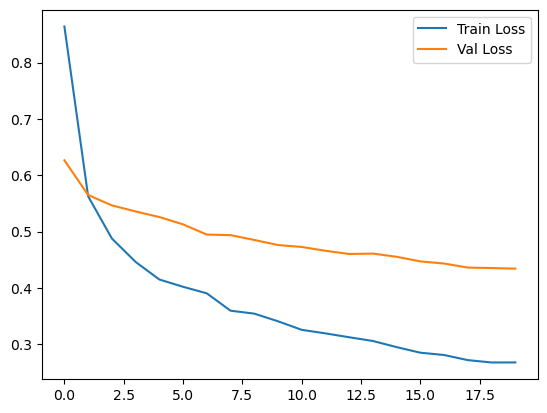

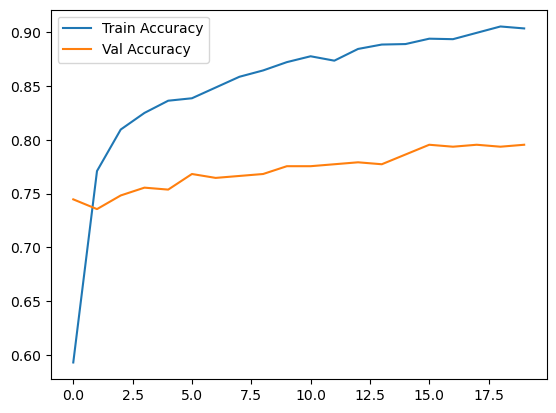

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- 1. Generator to convert Spark RDD data to tf.data.Dataset
def gen():
    for content, label in rdd_dataset.toLocalIterator():
        if isinstance(content, bytearray):
            content = bytes(content)
        if not isinstance(label, np.int32):
            label = np.int32(label)
        yield content, label

rdd_dataset = spark_df.select("content", "label").rdd

# --- 2. Build Dataset from Generator
dataset = tf.data.Dataset.from_generator(
    gen,
    output_types=(tf.string, tf.int32),
    output_shapes=(tf.TensorShape([]), tf.TensorShape([]))
)

# --- 3. Function to convert binary content to image and normalize it with size 299x299 (InceptionV3 requirements)
def preprocess(content, label):
    image = tf.io.decode_png(content, channels=1)
    image = tf.image.resize(image, [299, 299])  # Resize to 299x299
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# --- 4. Convert grayscale to RGB (3 channels)
def preprocess_inception(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

dataset_rgb = dataset.map(preprocess_inception, num_parallel_calls=tf.data.AUTOTUNE)

# --- 5. Split data (Example: 80% training and 20% validation)
dataset_size = dataset_rgb.reduce(0, lambda x, _: x + 1).numpy()
train_size = int(0.8 * dataset_size)
train_dataset = dataset_rgb.take(train_size)
val_dataset = dataset_rgb.skip(train_size)

# --- 6. Build InceptionV3 model with 3-class classification
num_classes = 3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 7. Prepare batches and prefetch for speed
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# --- 8. Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

# --- 9. Plot training results
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()


In [13]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)
import matplotlib.pyplot as plt

plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

Epoch 1/20
69/69 [==============================] - 109s 1s/step - loss: 1.4180 - accuracy: 0.4397 - val_loss: 0.7126 - val_accuracy: 0.6467
Epoch 2/20
69/69 [==============================] - 95s 1s/step - loss: 0.7716 - accuracy: 0.6770 - val_loss: 0.6027 - val_accuracy: 0.7428
Epoch 3/20
69/69 [==============================] - 95s 1s/step - loss: 0.6291 - accuracy: 0.7364 - val_loss: 0.5236 - val_accuracy: 0.7862
Epoch 4/20
69/69 [==============================] - 107s 2s/step - loss: 0.5459 - accuracy: 0.7917 - val_loss: 0.4961 - val_accuracy: 0.7917
Epoch 5/20
69/69 [==============================] - 107s 2s/step - loss: 0.4861 - accuracy: 0.8344 - val_loss: 0.4856 - val_accuracy: 0.8025
Epoch 6/20
69/69 [==============================] - 107s 2s/step - loss: 0.4207 - accuracy: 0.8698 - val_loss: 0.4754 - val_accuracy: 0.8098
Epoch 7/20
69/69 [==============================] - 104s 2s/step - loss: 0.3695 - accuracy: 0.8934 - val_loss: 0.4692 - val_accuracy: 0.8116
Epoch 8/20
69/6

1/1 [==============================] - 1s 1s/step


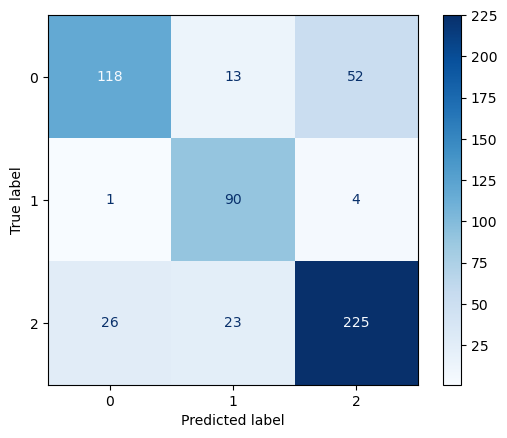

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


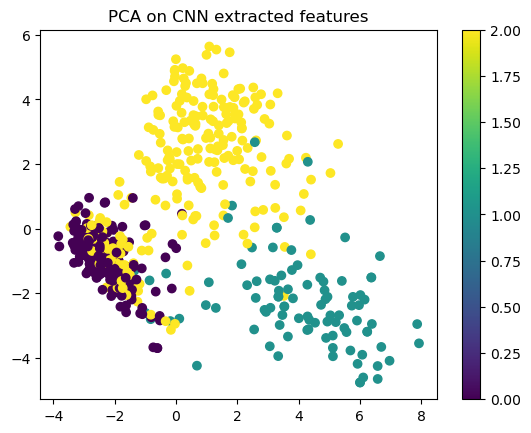

In [15]:
from sklearn.decomposition import PCA

# Extract features from the last layer before classification
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

features = []

for images, _ in val_dataset:
    feats = feature_extractor(images)
    features.append(feats.numpy())

features = np.concatenate(features, axis=0)

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
features_reduced = pca.fit_transform(features)

# Plot the results
plt.scatter(features_reduced[:, 0], features_reduced[:, 1], c=y_true, cmap='viridis')
plt.colorbar()
plt.title('PCA on CNN extracted features')
plt.show()


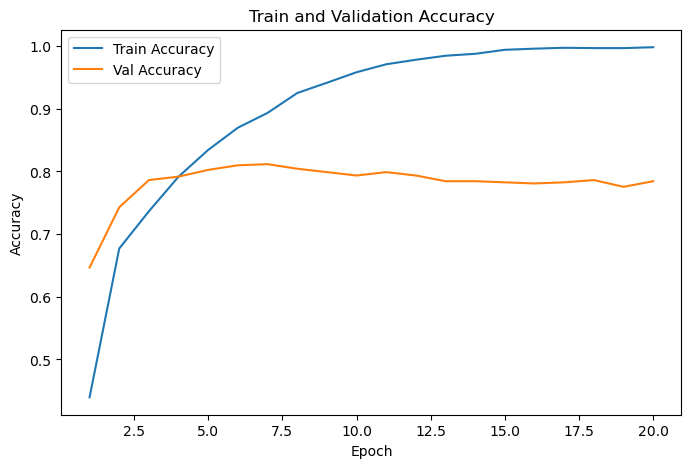

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#inception v3 after fine tuing 

plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Val Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(False)

plt.show()


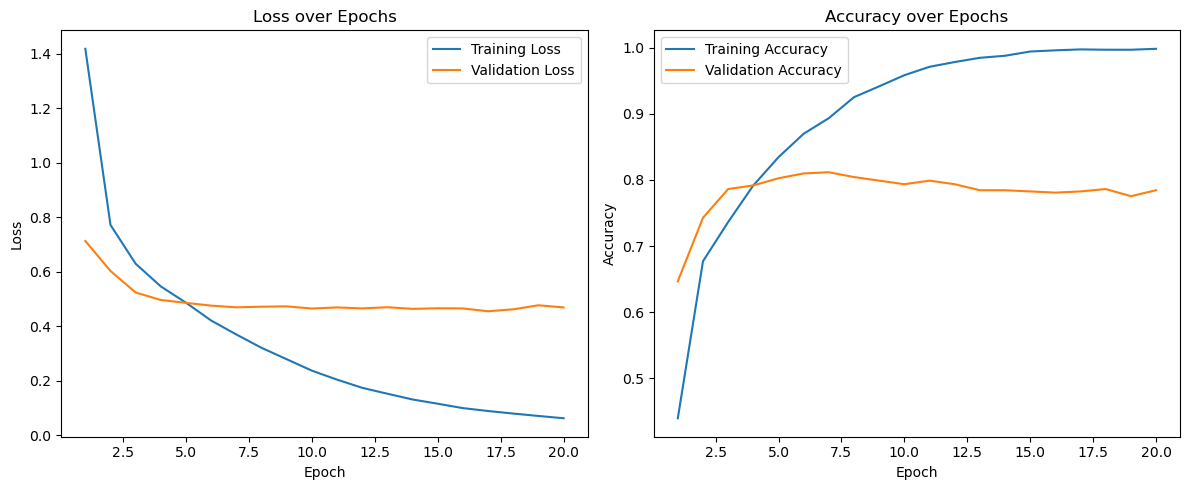

In [3]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 21)
#resnet50

plt.figure(figsize=(12, 5))

# رسم Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(False)

# رسم Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()
